In [1]:
# Importons les librairies dont nous avons besoin.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
%matplotlib inline
import numpy as np
import math
from sklearn import preprocessing
from sklearn import decomposition
import operator
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go 
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict

## Aperçu global
Commençons par charger le dataset en réordonnant les colonnes afin d'y voir plus clair.

In [2]:
data = pd.read_csv("movie_metadata.csv", header=0)
data = data[["movie_title", "director_name", "actor_1_name", "actor_2_name", "actor_3_name", "duration", "title_year", "country", "language", "genres", "director_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes", "num_critic_for_reviews", "num_user_for_reviews", "content_rating", "num_voted_users", "cast_total_facebook_likes", "facenumber_in_poster", "plot_keywords", "movie_imdb_link", "budget", "imdb_score", "aspect_ratio", "movie_facebook_likes", "color", "gross"]]
data.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,cast_total_facebook_likes,facenumber_in_poster,plot_keywords,movie_imdb_link,budget,imdb_score,aspect_ratio,movie_facebook_likes,color,gross
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,178.0,2009.0,USA,English,Action|Adventure|Fantasy|Sci-Fi,...,4834,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,237000000.0,7.9,1.78,33000,Color,760505847.0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,169.0,2007.0,USA,English,Action|Adventure|Fantasy,...,48350,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,300000000.0,7.1,2.35,0,Color,309404152.0
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,148.0,2015.0,UK,English,Action|Adventure|Thriller,...,11700,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,245000000.0,6.8,2.35,85000,Color,200074175.0
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164.0,2012.0,USA,English,Action|Thriller,...,106759,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,250000000.0,8.5,2.35,164000,Color,448130642.0
4,Star Wars: Episode VII - The Force Awakens ...,Doug Walker,Doug Walker,Rob Walker,NaN,NaN,NaN,NaN,NaN,Documentary,...,143,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,7.1,NaN,0,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
movie_title                  5043 non-null object
director_name                4939 non-null object
actor_1_name                 5036 non-null object
actor_2_name                 5030 non-null object
actor_3_name                 5020 non-null object
duration                     5028 non-null float64
title_year                   4935 non-null float64
country                      5038 non-null object
language                     5031 non-null object
genres                       5043 non-null object
director_facebook_likes      4939 non-null float64
actor_1_facebook_likes       5036 non-null float64
actor_2_facebook_likes       5030 non-null float64
actor_3_facebook_likes       5020 non-null float64
num_critic_for_reviews       4993 non-null float64
num_user_for_reviews         5022 non-null float64
content_rating               4740 non-null object
num_voted_users              5043 n

On remaque de nombreuses colonnes de type object contrairement au projet précédent. Nous aurons sûrement du one hot
encoding à effectuer. 
Observons déjà le remplissage de chaque colonne.

In [4]:
data.notnull().mean() * 100

movie_title                  100.000000
director_name                 97.937735
actor_1_name                  99.861194
actor_2_name                  99.742217
actor_3_name                  99.543922
duration                      99.702558
title_year                    97.858418
country                       99.900853
language                      99.762046
genres                       100.000000
director_facebook_likes       97.937735
actor_1_facebook_likes        99.861194
actor_2_facebook_likes        99.742217
actor_3_facebook_likes        99.543922
num_critic_for_reviews        99.008527
num_user_for_reviews          99.583581
content_rating                93.991672
num_voted_users              100.000000
cast_total_facebook_likes    100.000000
facenumber_in_poster          99.742217
plot_keywords                 96.966092
movie_imdb_link              100.000000
budget                        90.243902
imdb_score                   100.000000
aspect_ratio                  93.476105


Peu d'informations sont manquantes, il sera sûrement possible de remplir manuellement certaines données.

# Nettoyage des données

## Colonnes non pertinentes

Nous pouvons dans un premier temps commencer par nous séparer des colonnes dont nous n'aurons pas besoin pour notre modèle. 

### Gross

Les revenus du film ne nous sont a priori pas d'une grande utilité. Bien qu'ils puissent donner une indication sur la réussite d'un film, ce sont des informations que l'on peut obtenir via la note, le nombre de critiques...

In [5]:
data = data.drop(columns=["gross"], axis=1)

### Budget

Regardons le contenu de la colonne budget :

In [6]:
data["budget"]

0       237000000.0
1       300000000.0
2       245000000.0
3       250000000.0
4               NaN
5       263700000.0
6       258000000.0
7       260000000.0
8       250000000.0
9       250000000.0
10      250000000.0
11      209000000.0
12      200000000.0
13      225000000.0
14      215000000.0
15      225000000.0
16      225000000.0
17      220000000.0
18      250000000.0
19      225000000.0
20      250000000.0
21      230000000.0
22      200000000.0
23      225000000.0
24      180000000.0
25      207000000.0
26      200000000.0
27      250000000.0
28      209000000.0
29      150000000.0
           ...     
5013        24000.0
5014            NaN
5015        23000.0
5016        25000.0
5017        22000.0
5018        20000.0
5019            NaN
5020        17350.0
5021        15000.0
5022        15000.0
5023        15000.0
5024        20000.0
5025        10000.0
5026         4500.0
5027        10000.0
5028        10000.0
5029      1000000.0
5030            NaN
5031       200000.0


En comparant au site IMDB on s'aperçoit que la colonne budget semble  contenir des valeurs dans différentes monnaies. Par exemple le budget du film  Arn: The Knight Templar est en euro quand les films américains sont en dollar. Il s'agit d'une des colonnes les moins bien remplies et si elle pouvait nous donner des indications sur le fait qu'un film soit un blockbuster ou non nous devrions pouvoir le deviner à l'aide d'autres colonnes (facebook_like notamment). Nous n'avons donc aucune raison de garder cette colonne dans notre dataset.

In [7]:
data = data.drop(columns=["budget"], axis=1)

### Aspect Ratio

Regardons le contenu de la colonne aspect_ratio :

In [8]:
data["aspect_ratio"]

0        1.78
1        2.35
2        2.35
3        2.35
4         NaN
5        2.35
6        2.35
7        1.85
8        2.35
9        2.35
10       2.35
11       2.35
12       2.35
13       2.35
14       2.35
15       2.35
16       2.35
17       1.85
18       2.35
19       1.85
20       2.35
21       2.35
22       2.35
23       2.35
24       2.35
25       2.35
26       2.35
27       2.35
28       2.35
29       2.00
        ...  
5013     1.78
5014     2.35
5015     1.37
5016      NaN
5017     1.78
5018     1.85
5019     1.85
5020      NaN
5021      NaN
5022      NaN
5023     2.35
5024     2.35
5025     1.37
5026     2.35
5027     1.85
5028     1.33
5029     1.85
5030      NaN
5031    16.00
5032      NaN
5033     1.85
5034      NaN
5035     1.37
5036      NaN
5037      NaN
5038      NaN
5039    16.00
5040      NaN
5041     2.35
5042     1.85
Name: aspect_ratio, Length: 5043, dtype: float64

De la même façon, le ratio du film ne semble pas pertinent et celui-ci comporte des valeurs formattées différement. Prenons donc le partie de supprimer cette colonne.

In [9]:
data = data.drop(columns=["aspect_ratio"], axis=1)

### Movie imdb link et facenumber in poster
Enfin, nous pouvons supprimer ces deux colonnes qui ne nous est pas utile dans la recommandation de film.

In [10]:
data = data.drop(columns=["movie_imdb_link", "facenumber_in_poster"], axis=1)

## Formattage

Etant donné le nombre élevé de colonnes de type object commençons par nous assurer que celles-ci sont bien formattées.

In [11]:
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.str.strip())

## Valeurs manquantes
Comme nous l'avons vu certaines colonnes comportent des NaN qu'il devrait nous être possible de remplacer.
### Color
Compte tenu du fait que le premier film couleur est sorti en 1935 nous pouvons déjà combler certaines informations.

In [12]:
data.loc[(pd.isnull(data["color"])) & (data["title_year"] < 1935), ["color"]] = "Black and White"

Regardons la proportion de films en couleur depuis les années 2000 :

In [13]:
data[data["title_year"] >= 2000].groupby("color").size()

color
Black and White      91
Color              3492
dtype: int64

Celle-ci étant de près de 98% nous pouvons également combler certaines valeurs manquantes.

In [14]:
data.loc[(pd.isnull(data["color"])) & (data["title_year"] >= 2000), ["color"]] = "Color"

In [15]:
data.loc[(pd.isnull(data["color"]))]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,NaN,NaN,NaN,NaN,Documentary,...,NaN,NaN,NaN,NaN,8,143,NaN,7.1,0,NaN
279,"10,000 B.C.",Christopher Barnard,Mathew Buck,NaN,NaN,22.0,NaN,NaN,NaN,Comedy,...,NaN,NaN,NaN,NaN,6,5,NaN,7.2,0,NaN
459,Daredevil,NaN,Elden Henson,Royce Johnson,Charlie Cox,54.0,NaN,USA,English,Action|Adventure|Crime|Drama|Sci-Fi|Thriller,...,0.0,95.0,394.0,TV-MA,213483,581,corruption|lawyer|partnership|superhero|vigilante,8.8,55000,NaN
2459,Unforgettable,NaN,Poppy Montgomery,Dylan Walsh,Dallas Roberts,60.0,NaN,USA,NaN,Drama|Mystery,...,405.0,14.0,44.0,NaN,12854,1906,hyperthymesia|new york city|police,6.7,0,NaN
4846,Midnight Cabaret,Pece Dingo,Michael Des Barres,Wilhelm von Homburg,Thom Mathews,94.0,1990.0,USA,English,Horror,...,87.0,1.0,4.0,R,47,544,cigarette smoking|death|devil|nightmare|satani...,4.5,4,NaN


Il ne nous reste plus que certaines valeurs que nous pouvons remplir manuellement. Toutefois avant de nous lancer, nous pouvons remarquer la présence de séries dans notre dataset. Le but étant de fournir un générateur de recommandation pour film, nous pouvons tout de suite nous sépararer de ces lignes. Considérons toute ligne dont la duration est inférieure à 65 ou n'ayant pas de directeur comme étant une série ou un court métrage.

In [16]:
data = data[~((data["duration"] <= 65) | pd.isnull(data["director_name"]))]
data.loc[(pd.isnull(data["color"]))]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,NaN,NaN,NaN,NaN,Documentary,...,NaN,NaN,NaN,NaN,8,143,NaN,7.1,0,NaN
4846,Midnight Cabaret,Pece Dingo,Michael Des Barres,Wilhelm von Homburg,Thom Mathews,94.0,1990.0,USA,English,Horror,...,87.0,1.0,4.0,R,47,544,cigarette smoking|death|devil|nightmare|satani...,4.5,4,NaN


In [17]:
data.loc[4846, "color"] = "Color"
data.loc[4, ["color", "country", "language", "duration", "title_year"]] = ["Color", "USA", "English", 135, 2015]

### Language - Country
Occupons nous désormais des films dont la langue ou le pays ne sont pas renseignés.
Considérons par exemple que tout film Américain dont la langue n'est pas renseignée est en Anglais.

In [18]:
data.loc[(pd.isnull(data["language"])) & (data["country"] == "USA"), ["language"]] = "English"
data[pd.isnull(data["language"])]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color


In [19]:
data[pd.isnull(data["country"])]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color
4021,Dawn Patrol,Daniel Petrie Jr.,Chris Brochu,Jeff Fahey,Rita Wilson,88.0,2014.0,NaN,English,Drama|Thriller,...,322.0,9.0,13.0,NaN,455,2497,desert|held at gunpoint|marine|revenge|sex on ...,4.8,570,Color


In [20]:
data.loc[4021, "country"] = "USA"

### Duration - Title year
Remplissons désormais manuellement les valeurs manquantes pour les colonnes duration et title_year.

In [21]:
data[(pd.isnull(data["duration"])) | (pd.isnull(data["title_year"]))]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color
199,Harry Potter and the Deathly Hallows: Part II,Matt Birch,Rupert Grint,Dave Legeno,Ralph Ineson,NaN,2011.0,UK,English,Action|Fantasy,...,159.0,1.0,2.0,NaN,381,11036,NaN,7.5,40,Color
206,Harry Potter and the Deathly Hallows: Part I,Matt Birch,Rupert Grint,Toby Jones,Alfred Enoch,NaN,2010.0,UK,English,Fantasy,...,1000.0,4.0,2.0,NaN,252,14719,NaN,6.4,25,Color
1510,Black Water Transit,Tony Kaye,Bill Cobbs,Aisha Tyler,Beverly D'Angelo,NaN,2009.0,USA,English,Crime|Drama,...,816.0,NaN,NaN,NaN,219,3874,based on novel,7.2,26,Color
2870,Del 1 - Män som hatar kvinnor,Niels Arden Oplev,Michael Nyqvist,David Dencik,Lena Endre,88.0,NaN,Sweden,Swedish,Action|Crime|Mystery|Thriller,...,75.0,NaN,NaN,NaN,335,998,NaN,8.1,22,Color
3815,Should've Been Romeo,Marc Bennett,Michael Rapaport,Natasha Henstridge,Costas Mandylor,NaN,2012.0,USA,English,Comedy|Drama,...,723.0,2.0,2.0,NaN,38,4991,NaN,6.7,35,Color
3834,Barfi,Shekar,Bhama,Diganth,Dileep Raj,NaN,2013.0,India,Kannada,Comedy|Romance,...,0.0,1.0,1.0,NaN,57,5,NaN,7.1,2,Color
4299,Hum To Mohabbat Karega,Kundan Shah,Karisma Kapoor,Bobby Deol,Shakti Kapoor,NaN,2000.0,India,Hindi,Action|Comedy|Romance|Thriller,...,72.0,1.0,1.0,NaN,275,613,elevator|news reporter|police|restaurant|waiter,2.8,10,Color
4392,N-Secure,David M. Matthews,Essence Atkins,Lamman Rucker,Tempestt Bledsoe,NaN,2010.0,USA,English,Crime|Drama|Thriller,...,394.0,5.0,15.0,R,548,3137,betrayal|family relationships|insecurity|murde...,3.5,588,Color
4397,Dil Jo Bhi Kahey...,Romesh Sharma,Annabelle Wallis,Revathy,Bhoomika Chawla,NaN,2005.0,India,English,Romance,...,45.0,4.0,4.0,NaN,257,622,NaN,5.1,9,Color
4609,Karachi se Lahore,Wajahat Rauf,Rasheed Naz,Ayesha Omar,Javed Sheikh,NaN,2015.0,Pakistan,Urdu,Comedy|Family,...,4.0,6.0,15.0,NaN,876,19,pakistan|road trip,7.0,259,Color


On s'aperçoit que certaines séries sont encore présentes dans cette liste, profitons-en donc pour les supprimer.

In [22]:
series = [2870, 3815, 4690, 4948]
data = data[~data.index.isin(series)]

In [23]:
data.loc[199,"duration"] = 130
data.loc[206,"duration"] = 146
data.loc[1510,"duration"] = 120
data.loc[3834,"duration"] = 151
data.loc[4299,"duration"] = 153
data.loc[4392,"duration"] = 116
data.loc[4397,"duration"] = 144
data.loc[4609,"duration"] = 143
data.loc[4989,"duration"] = 90

## Valeurs aberrantes
Essayons de voir si certaines valeurs semblent irréalistes.

In [24]:
data.describe()

,duration,title_year,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,cast_total_facebook_likes,imdb_score,movie_facebook_likes
count,4912.000000,4912.000000,4912.000000,4906.000000,4903.000000,4897.000000,4875.000000,4900.000000,4.912000e+03,4912.000000,4912.000000,4912.000000
mean,108.493282,2002.479642,689.896580,6694.882185,1682.836223,653.581172,142.916923,277.419592,8.520934e+04,9882.664902,6.414292,7629.690554
std,22.184037,12.433754,2820.644295,15182.185919,4089.004078,1684.437491,121.654793,381.115618,1.398258e+05,18353.804749,1.114510,19492.588393
min,66.000000,1916.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000e+00,0.000000,1.600000,0.000000
25%,94.000000,1999.000000,7.000000,623.000000,284.000000,135.000000,53.000000,68.000000,9.104750e+03,1440.000000,5.800000,0.000000
50%,104.000000,2005.000000,49.000000,999.000000,602.000000,374.000000,112.000000,160.000000,3.531300e+04,3142.000000,6.500000,168.500000
75%,118.000000,2011.000000,197.000000,11000.000000,922.000000,638.000000,197.000000,332.000000,9.836625e+04,14106.750000,7.200000,3000.000000
max,330.000000,2016.000000,23000.000000,640000.000000,137000.000000,23000.000000,813.000000,5060.000000,1.689764e+06,656730.000000,9.300000,349000.000000


La seule colonne contenant des valeurs étonnantes est celle de la duration. Regardons cela plus en détails :

In [25]:
data[data["duration"] > 180]

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,actor_3_facebook_likes,num_critic_for_reviews,num_user_for_reviews,content_rating,num_voted_users,cast_total_facebook_likes,plot_keywords,imdb_score,movie_facebook_likes,color
10,Batman v Superman: Dawn of Justice,Zack Snyder,Henry Cavill,Lauren Cohan,Alan D. Purwin,183.0,2016.0,USA,English,Action|Adventure|Sci-Fi,...,2000.0,673.0,3018.0,PG-13,371639,24450,based on comic book|batman|sequel to a reboot|...,6.9,197000,Color
23,The Hobbit: The Desolation of Smaug,Peter Jackson,Aidan Turner,Adam Brown,James Nesbitt,186.0,2013.0,USA,English,Adventure|Fantasy,...,773.0,509.0,951.0,PG-13,483540,9152,dwarf|elf|lake town|mountain|sword and sorcery,7.9,83000,Color
25,King Kong,Peter Jackson,Naomi Watts,Thomas Kretschmann,Evan Parke,201.0,2005.0,New Zealand,English,Action|Adventure|Drama|Romance,...,84.0,446.0,2618.0,PG-13,316018,7123,animal name in title|ape abducts a woman|goril...,7.2,0,Color
26,Titanic,James Cameron,Leonardo DiCaprio,Kate Winslet,Gloria Stuart,194.0,1997.0,USA,English,Drama|Romance,...,794.0,315.0,2528.0,PG-13,793059,45223,artist|love|ship|titanic|wet,7.7,26000,Color
32,Iron Man 3,Shane Black,Robert Downey Jr.,Jon Favreau,Don Cheadle,195.0,2013.0,USA,English,Action|Adventure|Sci-Fi,...,3000.0,608.0,1187.0,PG-13,557489,30426,armor|explosion|human bomb|missile attack|terr...,7.2,95000,Color
99,The Hobbit: An Unexpected Journey,Peter Jackson,Aidan Turner,Adam Brown,James Nesbitt,182.0,2012.0,USA,English,Adventure|Fantasy,...,773.0,645.0,1367.0,PG-13,637246,9152,dragon|dwarf|hobbit|orc|wizard,7.9,166000,Color
111,Pearl Harbor,Michael Bay,Jennifer Garner,Jaime King,Mako,184.0,2001.0,USA,English,Action|Drama|History|Romance|War,...,691.0,191.0,1999.0,PG-13,254111,5401,air raid|black smoke|japanese military|japanes...,6.1,0,Black and White
113,Alexander,Oliver Stone,Anthony Hopkins,Angelina Jolie Pitt,Brian Blessed,206.0,2004.0,Germany,English,Action|Adventure|Biography|Drama|History|Roman...,...,591.0,248.0,1390.0,R,138863,24598,ancient greece|conquest|greek|greek myth|king,5.5,0,Color
147,Troy,Wolfgang Petersen,Brad Pitt,Orlando Bloom,Julian Glover,196.0,2004.0,USA,English,Adventure,...,844.0,220.0,1694.0,R,381672,17944,greek|mythology|prince|trojan|troy,7.2,0,Color
165,Watchmen,Zack Snyder,Matt Frewer,Billy Crudup,Stephen McHattie,215.0,2009.0,USA,English,Action|Drama|Mystery|Sci-Fi,...,413.0,451.0,1229.0,R,392474,2530,conspiracy|cynicism|false promise of the ameri...,7.7,18000,Color


Il s'agit bien de valeurs exactes correspondant à des films plus longs que la moyenne. Toutefois, on remarque que des doublons se sont glissés dans notre dataset (King-King notamment).

## Doublons
Supprimons donc les films ayant le même titre et le même réalisateur.

In [26]:
data = data.drop_duplicates(subset=['movie_title', "director_name"])

## One hot encoding
Nous avons dans notre dataset plusieurs colonnes de type catégorie contenant des strings (genre, color...) que nous devons transformer en chiffres afin de pouvoir les utiliser dans notre modèle.

### Genres
Commençons par voir tous les genres différents dont nous disposons.

In [27]:
genres = set('|'.join(data["genres"].values).split('|'))
genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

Créons désormais une colonne par genre et remplissons la de 0 ou de 1 selon que le film appartienne ou non à chacun des genres.

In [28]:
for genre in genres:
    data["genre_{}".format(genre.lower())] = data["genres"].str.contains(genre).astype(int)
data.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,language,genres,...,genre_sport,genre_history,genre_fantasy,genre_war,genre_adventure,genre_horror,genre_romance,genre_crime,genre_drama,genre_biography
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,178.0,2009.0,USA,English,Action|Adventure|Fantasy|Sci-Fi,...,0,0,1,0,1,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,169.0,2007.0,USA,English,Action|Adventure|Fantasy,...,0,0,1,0,1,0,0,0,0,0
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,148.0,2015.0,UK,English,Action|Adventure|Thriller,...,0,0,0,0,1,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164.0,2012.0,USA,English,Action|Thriller,...,0,0,0,0,0,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,135.0,2015.0,USA,English,Documentary,...,0,0,0,0,0,0,0,0,0,0


### Language - Country - Director name
L'idée est d'effectuer la même chose pour ces trois colonnes, qui, comme nous allons le voir peuvent être traitées de la même façon. Toutefois, plutôt que de garder la langue et le pays du film, il semble plus pertinent de ne garder que le pays. En effet, il est aujourd'hui possible de regarder n'importe quel film dans la langue de son choix, il serait donc dommage d'éliminer des films en fonction de leur langue d'origine alors qu'ils sont disponibles dans d'autres langues.
De plus, ces deux colonnes ne diffèrent que peu, ainsi les personnes voulant absolument un film dans une certaine langue pourront se fier au pays de façon presque certaine.

In [29]:
data = data.drop(columns="language")

Regardons désormais la fréquence des pays et des directeurs.

In [30]:
countries = data.fillna("").groupby("country").size().sort_values()
countries

country
Afghanistan              1
New Line                 1
Nigeria                  1
Indonesia                1
Official site            1
Pakistan                 1
Panama                   1
Georgia                  1
Peru                     1
Finland                  1
Egypt                    1
Dominican Republic       1
Libya                    1
Philippines              1
Kyrgyzstan               1
Slovakia                 1
Chile                    1
Slovenia                 1
Cameroon                 1
Cambodia                 1
Bulgaria                 1
Soviet Union             1
Colombia                 1
Turkey                   1
Aruba                    1
Bahamas                  1
Taiwan                   2
Poland                   2
Hungary                  2
Iceland                  2
                      ... 
Belgium                  3
Czech Republic           3
Romania                  4
Israel                   4
Iran                     4
Argentina           

In [31]:
directors = data.fillna("").groupby("director_name").size().sort_values()
directors

director_name
A. Raven Cruz             1
Maksim Fadeev             1
Majid Majidi              1
Maggie Greenwald          1
Maggie Carey              1
Mabrouk El Mechri         1
Mabel Cheung              1
Lynn Shelton              1
Luke Dye                  1
Lukas Moodysson           1
Luis Valdez               1
Lucrecia Martel           1
Malcolm Goodwin           1
Lucky McKee               1
Lucile Hadzihalilovic     1
Luca Guadagnino           1
Luc Jacquet               1
Lowell Sherman            1
Louis Morneau             1
Louis C.K.                1
Lori Silverbush           1
Lori Petty                1
Lorene Scafaria           1
Lluís Quílez              1
Lloyd Kaufman             1
Lucio Fulci               1
Lloyd Bacon               1
Mamoru Hosoda             1
Marc F. Adler             1
Mark Sandrich             1
                         ..
John McTiernan           10
John Carpenter           10
Stephen Frears           10
Paul W.S. Anderson       10
Sam Ra

Plutôt que d'avoir de nombreuses colonnes remplies de 0 nous allons prendre le parti de supprimer les pays et directeurs rares. Sont ici considérées comme rares toutes les valeurs apparaissant moins de 5 fois.

In [32]:
columns = ["country", "director_name"]

for column in columns:
    items = data.fillna("").groupby(column).size().sort_values()
    common_items = items[items.values > 4].index

    for item in common_items:
        data["{}_{}".format(column, item.lower())] = (data[column] == item).astype(int)
data.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,genres,director_facebook_likes,...,director_name_tim burton,director_name_oliver stone,director_name_steven soderbergh,director_name_renny harlin,director_name_ridley scott,director_name_spike lee,director_name_martin scorsese,director_name_clint eastwood,director_name_woody allen,director_name_steven spielberg
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,169.0,2007.0,USA,Action|Adventure|Fantasy,563.0,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,148.0,2015.0,UK,Action|Adventure|Thriller,0.0,...,0,0,0,0,0,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164.0,2012.0,USA,Action|Thriller,22000.0,...,0,0,0,0,0,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,135.0,2015.0,USA,Documentary,131.0,...,0,0,0,0,0,0,0,0,0,0


### Content Rating

In [33]:
data["content_rating"] = data["content_rating"].fillna("Unrated")
content_ratings = data["content_rating"].unique()
content_ratings

array(['PG-13', 'Unrated', 'PG', 'G', 'R', 'TV-14', 'Not Rated',
       'Approved', 'NC-17', 'X', 'GP', 'Passed', 'M', 'TV-G', 'TV-PG'],
      dtype=object)

On s'aperçoit que le format ne semble par régulier ("Not Rated" et "Unrated" par exemple). En regardant la documentation, on s'aperçoit qu'il est possible de regrouper ces valeurs en 6 classes :
R

NC-17, X

PG, GP, TV-PG

TV-14, PG-13

G, TV-G, Passed, Approved

Unrated, Not Rated

In [34]:
for content_rating in content_ratings:
    data[content_rating.lower()] = (data["content_rating"] == content_rating).astype(int)
data["pg-13"] = data["pg-13"] + data["tv-14"]
data["g"] = data["g"] + data["tv-g"] + data["passed"] + data["approved"]
data["pg"] = data["pg"] + data["gp"] + data["tv-pg"]
data["nc-17"] = data["nc-17"] + data["x"]
data = data.drop(columns=["unrated", "not rated", "content_rating", "tv-g", "passed", "approved", "pg", "gp", "tv-pg", "x"])
data.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,genres,director_facebook_likes,...,director_name_martin scorsese,director_name_clint eastwood,director_name_woody allen,director_name_steven spielberg,pg-13,g,r,tv-14,nc-17,m
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,0.0,...,0,0,0,0,1,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,169.0,2007.0,USA,Action|Adventure|Fantasy,563.0,...,0,0,0,0,1,0,0,0,0,0
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,148.0,2015.0,UK,Action|Adventure|Thriller,0.0,...,0,0,0,0,1,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164.0,2012.0,USA,Action|Thriller,22000.0,...,0,0,0,0,1,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,135.0,2015.0,USA,Documentary,131.0,...,0,0,0,0,0,0,0,0,0,0


### Color
Afin d'éliminer toute confusion renommons tout d'abord la colonne "color" en "colors" puis continuons notre one hot encoding.

In [35]:
data["colors"] = data["color"]
data = data.drop(columns=["color"])

In [36]:
colors = data["colors"].unique()
for color in colors:
    data["color_{}".format(color.lower())] = (data["colors"] == color).astype(int)
data.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,duration,title_year,country,genres,director_facebook_likes,...,director_name_steven spielberg,pg-13,g,r,tv-14,nc-17,m,colors,color_color,color_black and white
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,0.0,...,0,1,0,0,0,0,0,Color,1,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,169.0,2007.0,USA,Action|Adventure|Fantasy,563.0,...,0,1,0,0,0,0,0,Color,1,0
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,148.0,2015.0,UK,Action|Adventure|Thriller,0.0,...,0,1,0,0,0,0,0,Color,1,0
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164.0,2012.0,USA,Action|Thriller,22000.0,...,0,1,0,0,0,0,0,Color,1,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,Doug Walker,Rob Walker,NaN,135.0,2015.0,USA,Documentary,131.0,...,0,0,0,0,0,0,0,Color,1,0


### Actors
Il n'y a pas d'intérêts d'avoir 3 colonnes différentes selon l'importance de l'acteur. Nous allons donc traiter uniformément les acteurs qu'ils soient 1, 2 ou 3 en rang d'importance.

In [37]:
data["actors"] = data["actor_1_name"] + "|" + data["actor_2_name"] + "|" + data["actor_3_name"]
actors = list(set("|".join(data["actors"].fillna("").values).split("|")))[1:-1]
for actor in actors:
    data[actor.lower().replace(" ", "_")] = ((data["actor_1_name"] == actor) | (data["actor_2_name"] == actor) | (data["actor_3_name"] == actor)).astype(int)
data = data.drop(columns=["actor_1_name", "actor_2_name", "actor_3_name"], axis=1)
data.head()

,movie_title,director_name,duration,title_year,country,genres,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,...,mike_o'malley,kirsten_collins,angelica_lee,kayvan_novak,tony_goldwyn,lisa_edelstein,kay_panabaker,phil_vischer,kenneth_williams,simon_woods
0,Avatar,James Cameron,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,0.0,1000.0,936.0,855.0,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,169.0,2007.0,USA,Action|Adventure|Fantasy,563.0,40000.0,5000.0,1000.0,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,Sam Mendes,148.0,2015.0,UK,Action|Adventure|Thriller,0.0,11000.0,393.0,161.0,...,0,0,0,0,0,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,164.0,2012.0,USA,Action|Thriller,22000.0,27000.0,23000.0,23000.0,...,0,0,0,0,0,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,135.0,2015.0,USA,Documentary,131.0,131.0,12.0,NaN,...,0,0,0,0,0,0,0,0,0,0


De même que pour les directeurs ou les pays, supprimons tous les acteurs apparaissant moins de 5 fois.

In [40]:
other_actors = data.loc[:,"color_black and white":].sum()
other_actors = other_actors[other_actors.values < 5].index
data = data.drop(columns=other_actors, axis=1)
data.head()

,movie_title,director_name,duration,title_year,country,genres,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,...,rachael_harris,john_ratzenberger,carol_kane,sarah_michelle_gellar,bailee_madison,bokeem_woodbine,leonard_nimoy,bernie_mac,desmond_llewelyn,tony_goldwyn
0,Avatar,James Cameron,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,0.0,1000.0,936.0,855.0,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,169.0,2007.0,USA,Action|Adventure|Fantasy,563.0,40000.0,5000.0,1000.0,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,Sam Mendes,148.0,2015.0,UK,Action|Adventure|Thriller,0.0,11000.0,393.0,161.0,...,0,0,0,0,0,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,164.0,2012.0,USA,Action|Thriller,22000.0,27000.0,23000.0,23000.0,...,0,0,0,0,0,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,135.0,2015.0,USA,Documentary,131.0,131.0,12.0,NaN,...,0,0,0,0,0,0,0,0,0,0


### Facebook likes
Nous pouvons effectuer la même chose sur les facebook likes et les sommer en une seule colonne. Toutefois, cela reviendra à calculer le cast_total_facebook_likes. Nous pouvons donc supprimer les trois colonnes de likes par acteur.

In [41]:
data = data.drop(columns=["actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes", "director_facebook_likes"])

Regardons le nombre de colonnes de type object qu'il nous reste.

In [42]:
data[data.select_dtypes(['object']).columns].head()

,movie_title,director_name,country,genres,plot_keywords,colors,actors
0,Avatar,James Cameron,USA,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,Color,CCH Pounder|Joel David Moore|Wes Studi
1,Pirates of the Caribbean: At World's End,Gore Verbinski,USA,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,Color,Johnny Depp|Orlando Bloom|Jack Davenport
2,Spectre,Sam Mendes,UK,Action|Adventure|Thriller,bomb|espionage|sequel|spy|terrorist,Color,Christoph Waltz|Rory Kinnear|Stephanie Sigman
3,The Dark Knight Rises,Christopher Nolan,USA,Action|Thriller,deception|imprisonment|lawlessness|police offi...,Color,Tom Hardy|Christian Bale|Joseph Gordon-Levitt
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,USA,Documentary,NaN,Color,NaN


Il ne nous en reste qu'une à traiter : plot_keywords (la colonne movie_title sera laissée telle quelle et ne sera pas utilisée pour notre modèle). Nous avons décider de la traiter séparément puisqu'elle nécessite plus d'attention. 

### Plot Keywords

Commençons par effectuer le même travail que celui effectué sur les genres, afin de séparer tous les mot-clefs en colonnes.

In [43]:
keywords = set('|'.join(data.fillna("")["plot_keywords"].values).split('|'))
keywords.remove("")
len(keywords)

7956

On remarque ici que le nombre de mots est très important, il ne nous sera donc pas possible de réutiliser la même technique que précédemment. Il nous faut un moyen de regrouper certains mots. Commençons par les grouper par racine commune à l'aide de la librairie SnowballStemmer et décidons de ne garder que les racines apparaissant au moins 10 fois.

In [44]:
stemmer = SnowballStemmer("english")
common_keywords = {}
common_keywords = defaultdict(lambda:0,common_keywords)
for index, row in data.iterrows():
    row_keywords = []
    if pd.notnull(row["plot_keywords"]):
        keywords = row["plot_keywords"].split('|')
        for keyword in keywords:
            common_keywords[stemmer.stem(keyword.lower())] += 1
            row_keywords.append(stemmer.stem(keyword.lower()))
    data.loc[index, "plot_keywords"] = "|".join(row_keywords)
final_keywords = {k: v for k, v in common_keywords.items() if v >= 10}
len(final_keywords)

413

Nous avons divisé par près de 20 notre nombre de mots et avons par la même occasion remplacé tous les mots de la colonne plot_keywords par leur racine. Nous pouvons désormais nous servir de ces derniers pour former nos colonnes et terminer notre one hot encoding.

In [45]:
for keyword in final_keywords:
    data[keyword] = ((data["plot_keywords"].str.contains(keyword)) | (data["movie_title"].str.contains(keyword))).astype(int)
data.head()

,movie_title,director_name,duration,title_year,country,genres,num_critic_for_reviews,num_user_for_reviews,num_voted_users,cast_total_facebook_likes,...,summer,jason voorhe,found footag,killer,irish,independent film,satir,supernatur,oral sex,mormon
0,Avatar,James Cameron,178.0,2009.0,USA,Action|Adventure|Fantasy|Sci-Fi,723.0,3054.0,886204,4834,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,169.0,2007.0,USA,Action|Adventure|Fantasy,302.0,1238.0,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,Sam Mendes,148.0,2015.0,UK,Action|Adventure|Thriller,602.0,994.0,275868,11700,...,0,0,0,0,0,0,0,0,0,0
3,The Dark Knight Rises,Christopher Nolan,164.0,2012.0,USA,Action|Thriller,813.0,2701.0,1144337,106759,...,0,0,0,0,0,0,0,0,0,0
4,Star Wars: Episode VII - The Force Awakens,Doug Walker,135.0,2015.0,USA,Documentary,NaN,NaN,8,143,...,0,0,0,0,0,0,0,0,0,0


C'est ici que se termine le nettoyage de notre dataset, vérifions que le remplissage de nos colonnes est total et nous permettra d'effectuer notre exploration.

In [46]:
data.notnull().mean() * 100

movie_title                  100.000000
director_name                100.000000
duration                     100.000000
title_year                   100.000000
country                      100.000000
genres                       100.000000
num_critic_for_reviews        99.248434
num_user_for_reviews          99.749478
num_voted_users              100.000000
cast_total_facebook_likes    100.000000
plot_keywords                100.000000
imdb_score                   100.000000
movie_facebook_likes         100.000000
genre_western                100.000000
genre_thriller               100.000000
genre_animation              100.000000
genre_mystery                100.000000
genre_music                  100.000000
genre_action                 100.000000
genre_comedy                 100.000000
genre_news                   100.000000
genre_film-noir              100.000000
genre_family                 100.000000
genre_documentary            100.000000
genre_musical                100.000000


A ce stade, seules les colonnes num_critic_for_reviews et num_user_for_reviews ne sont pas remplis totalement. Du fait du faible nombre de valeurs manquantes nous pourrions remplir les données manuellement. Toutefois, ces colonnes semblent moins pertinentes que le num_voted_users qui indique à lui seul la popularité d'un film. Prenons donc le parti de supprimer les deux autres colonnes.

In [47]:
data = data.drop(columns=["num_critic_for_reviews", "num_user_for_reviews"])

# Exploration

Il est désormais temps de regarder un peu plus en détails ce que contient notre dataset. Commençons par utiliser des wordclouds dans un premier temps.

## Wordcloud
Créons une fonction pour calculer la fréquence d'apparition de chaque valeur sous forme d'une list de tuple contenant le nom et la fréquence d'apparition ainsi qu'une fonction de visualisation sous forme de wordcloud.

In [48]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float: continue        
        for s in [s for s in liste_keywords if s in liste]: 
            keyword_count[s] += 1
    return keyword_count

In [49]:
def wordcloud(keywords_count, index):
    words = dict()
    for keyword_count in keywords_count[0:50]:
        words[keyword_count[0]] = keyword_count[1]

    ax1 = fig.add_subplot(4,1,index)

    wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                          max_words=1628,relative_scaling=1,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

Regarons désormais ce que cela donne pour les genres, mots, directeurs et acteurs. Affichons en même temps les huit plus grandes valeurs sous formes d'histogrammes afin d'avoir des données chiffrées.

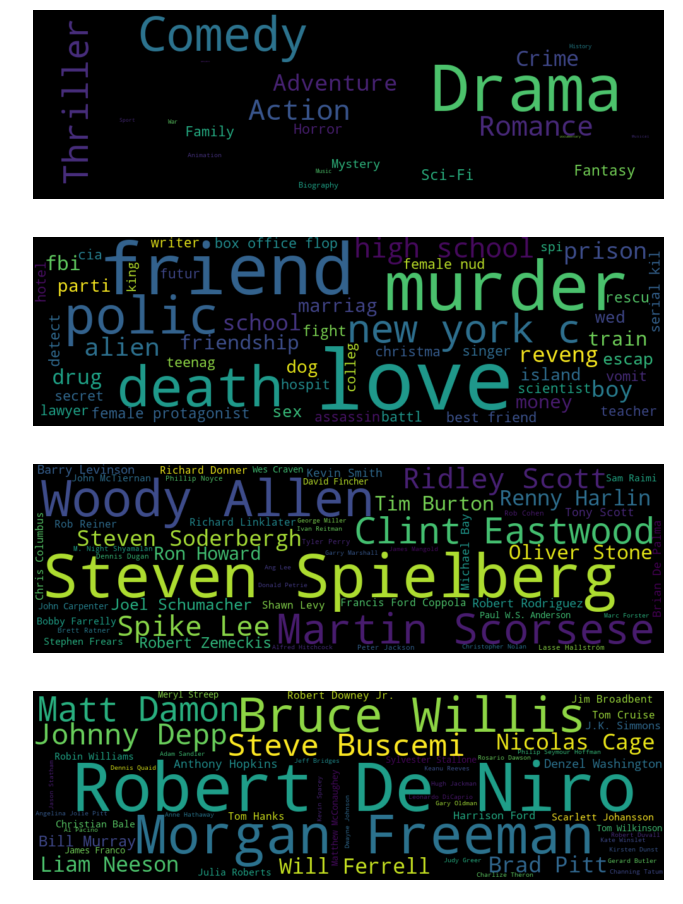

In [50]:
fig = plt.figure(1, figsize=(16,16))

i = 1
for column in ["genres", "plot_keywords", "director_name", "actors"]:
    set_items = list(set('|'.join(data.fillna("")[column].values).split('|')))
    if "" in set_items: set_items.remove("") 
    items_count = sorted(count_word(data, column, set_items).items(), key=operator.itemgetter(1), reverse=True)
    wordcloud(items_count, i)       
    i = i + 1

## Histogramme

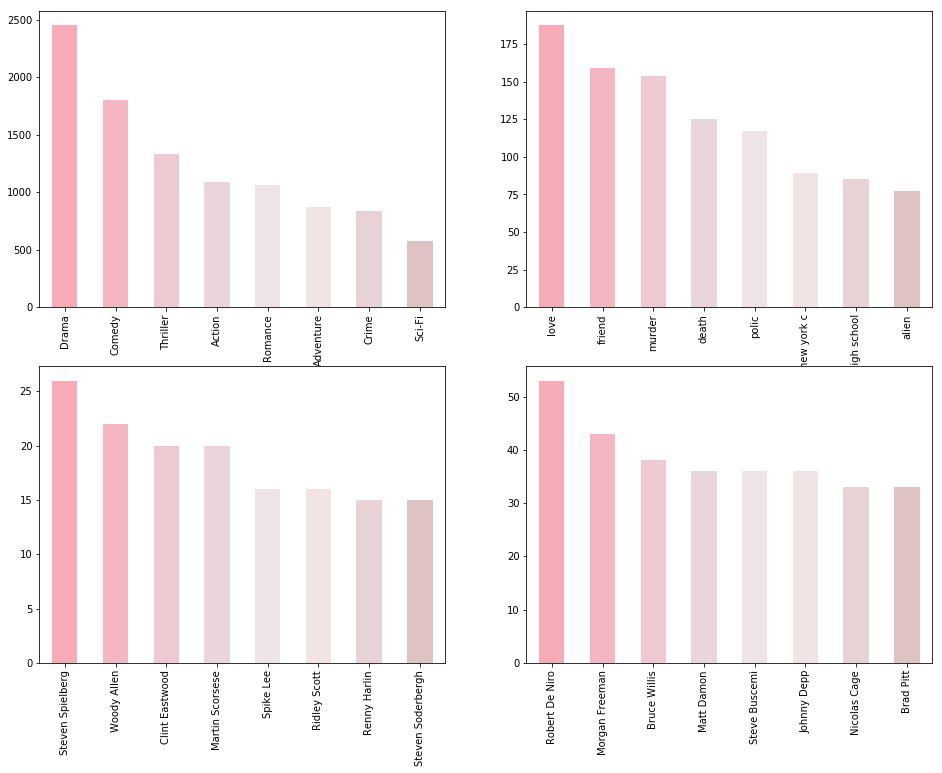

In [56]:
fig = plt.figure(1, figsize=(16,12))

i = 1
for column in ["genres", "plot_keywords", "director_name", "actors"]:
    set_items = list(set('|'.join(data.fillna("")[column].values).split('|')))
    if "" in set_items: set_items.remove("") 
    items_count = pd.Series(count_word(data, column, set_items))
    ax1 = fig.add_subplot(2,2,i)
    items_count.sort_values(ascending = False).head(8).plot(kind = 'bar', color=["#f6abb6", "#f4b6c2", "#eec9d2", "#ead5dc", "#eee3e7",  "#f0e4e4", "#e7d3d3", "#dec3c3"], grid=False)
    i = i + 1

Sans nous donner spécialement d'information sur notre dataset on peut toutefois vérifier que celui-ci semble constitué de valeurs cohérentes, puisque l'on retrouve les acteurs et directeurs les plus connus dans nos différents histogrammes.

## Pie chart

Regardons ce qu'il en est de la répartition des films par années. Afin d'y voir plus clair, regroupons les par décennies en commençant en 1970 (ce qui représente 95% du dataset) :

In [59]:
len(data[data["title_year"].isin(range(1970, 2016))]) / len(data) * 100

94.98956158663883

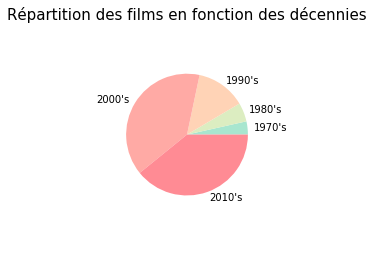

In [60]:
years = {"1970's":1970, "1980's":1980, "1990's":1990, "2000's":2000, "2010's":2000}
for name, year in years.items():
    data[name] = ((year - data["title_year"] < 10) & (year - data["title_year"] > 0)).astype(int)
    
counts = data.loc[:, "1970's":"2010's"].sum()
figure = plt.figure()
plt.subplot(1, 2, 1)
plt.title("Répartition des films en fonction des décennies",fontsize=15)
plt.axis('equal')
plt.pie(counts, labels = counts.index, colors=["#a8e6cf", "#dcedc1", "#ffd3b6", "#ffaaa5", "#ff8b94"])
plt.show()

data = data.drop(columns=data.loc[:,"1970's":"2010's"].columns)

On remarque que la majorité des films datent des années 2000 ou après, ce qui nous confirme dans le choix d'avoir éliminé la langue comme critère, la quasi totalité des films étant disponibles dans la langue de son choix désormais.

## Scatter plot

Regardons s'il nous est possible de visualiser des corrélations entre certaines variables.

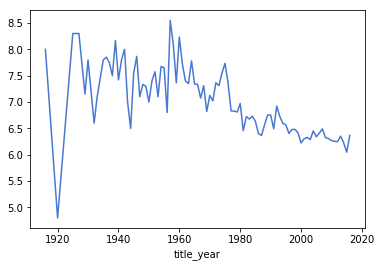

In [61]:
data.groupby('title_year').mean()['imdb_score'].plot(grid=False)

Hormis une valeur extrême en 1920, on remarque que globalement le score imdb décline au fil du temps.

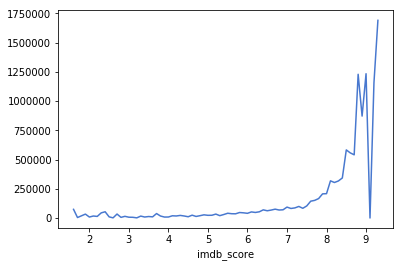

In [62]:
data.groupby('imdb_score').mean()['num_voted_users'].plot(grid=False)

Au contraire, plus le nombre de votes augmente mieux le film est noté. Cela peut mettre en avant un effet blockbuster, films à succès très populaires, vus par des millions de personnes qui vont le noter positivement. Effet que l'on retrouverait dans le nombre de likes facebook probablement. 

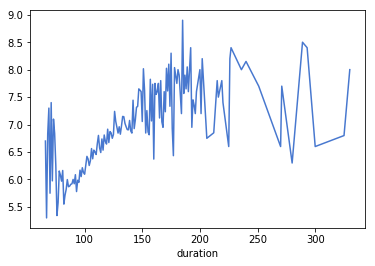

In [63]:
data.groupby('duration').mean()['imdb_score'].plot(grid=False)

On peut apercevoir une légère corrélation entre la durée et le score d'un film. Là encore les films longs sont souvent des blockbusters ou des films à gros budget ce qui peut expliquer ce comportement. 

Continuons notre analyse avec des boites à moustaches.

## Boxplot

Essayons de voir si le score est également lié au pays, à la couleur ou non et au genre du film à l'aide de boxplots.

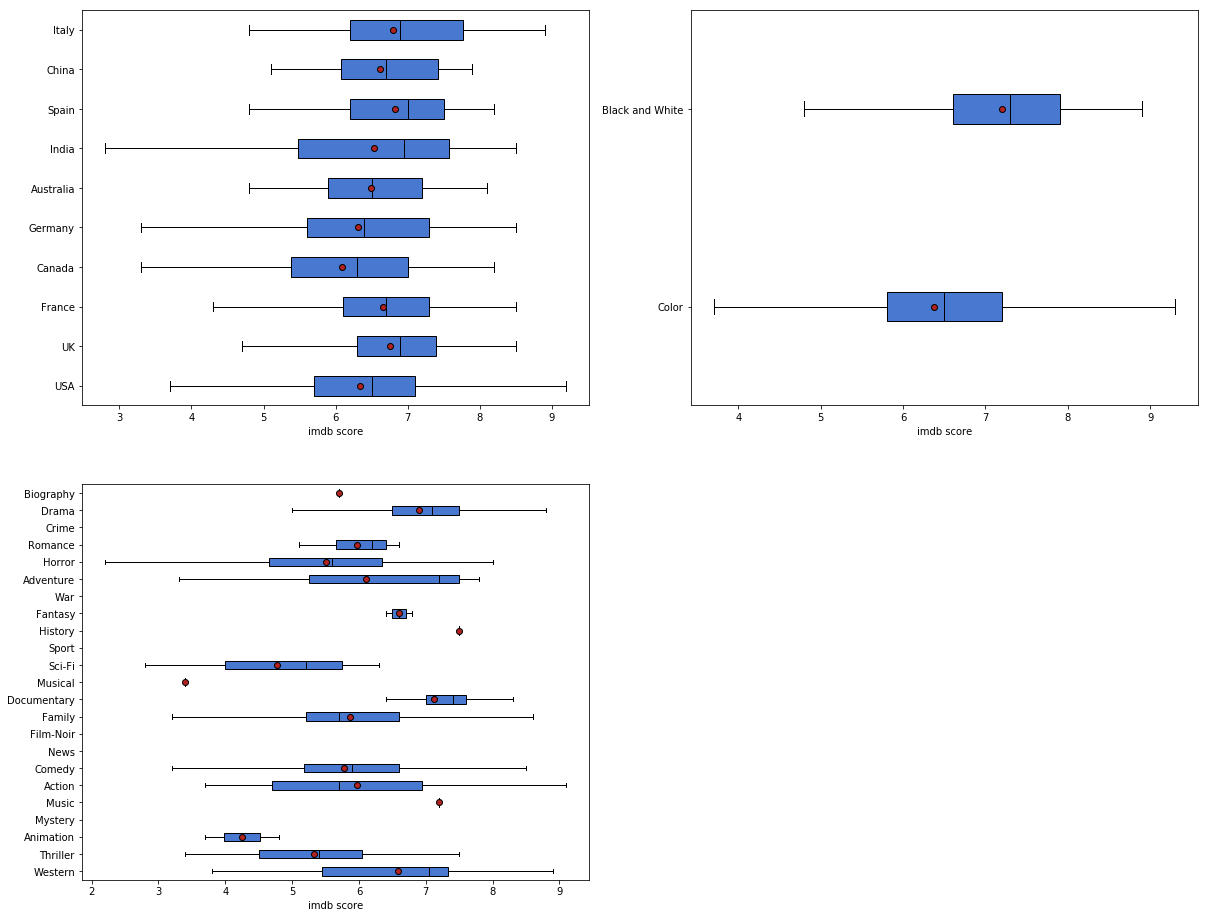

In [64]:
modalites = ["USA", "UK", "France", "Canada", "Germany", "Australia", "India", "Spain", "China", "Italy"]
plt.figure(figsize=[20,16])

groupes = []
for m in modalites:
    groupes.append(data[data['country'] == m]['imdb_score'].values.reshape(-1, 1))

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.subplot(2, 2, 1)
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('imdb score')

modalites = ["Color", "Black and White"]

groupes = []
for m in modalites:
    groupes.append(data[data['colors'] == m]['imdb_score'].values.reshape(-1, 1))

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.subplot(2, 2, 2)
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('imdb score')

modalites = list(set('|'.join(data["genres"].values).split('|')))

groupes = []
for m in modalites:
    groupes.append(data[data['genres'] == m]['imdb_score'].values.reshape(-1, 1))

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.subplot(2, 2, 3)
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('imdb score')
plt.show()

Il semble difficile de voir un réel impact du pays sur le score imdb. Toutefois, on peut noter que le scope des notes de films Indiens est bien plus large que celui des films Anglais par exemple.

Les films en noir et blanc sont globalement mieux notés, ce qui confirme ce que nous avions vu via la corrélation négative de la colonne title_year.

Concernant les genres, la distribution est bien plus éparse. En ne considérant que les principaux genres, on remarque notamment que les drames sont globalement mieux notés que les films de sciences fiction par exemple. Cela semble donc être une colonne clef dans l'attribution du score.

Vérifions cela via la méthode ANOVA.

## ANOVA

Regardons si le coefficient obtenu via la méthode ANOVA confirme notre intuition selon laquelle le genre influe sur la note du film.

In [65]:
X = "genres"
Y = "imdb_score"

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(data[X],data[Y])

0.3653394241392207

On obtient un résultat proche de 0.4, ce qui laisse penser qu'il y a effectivement une corrélation entre le genre des films et leur score sur imdb.

## Map

Bien que cela ne fasse aucun doute, affichons sous forme de carte la répartition du nombre de films par pays. Afin de mieux visualiser les résultats, utilisons la fonction logarithme afin de réduire les écarts.

In [66]:
import plotly.plotly as py

ln_countries = pd.Series(np.log(countries.values), index = countries.index)

map = [dict(type = 'choropleth',
           locations = ln_countries.index,
           locationmode = 'country names',
           colorscale =  [[1.0, 'rgb(165,0,38)'], [0.8888888888888888, 'rgb(215,48,39)'], [0.7777777777777778, 'rgb(244,109,67)'], [0.6666666666666666, 'rgb(253,174,97)'], [0.5555555555555556, 'rgb(254,224,144)'], [0.4444444444444444, 'rgb(224,243,248)'], [0.3333333333333333, 'rgb(171,217,233)'], [0.2222222222222222, 'rgb(116,173,209)'], [0.1111111111111111, 'rgb(69,117,180)'], [0.0, 'rgb(49,54,149)']],
           text = countries.values,
           z = ln_countries.values,
           colorbar = {'title': 'log of Sum of Movies'})]

layout = dict(title = 'Movies Filmed in Countries around the World',
             geo = dict(showframe = False,
                       projection = {'type': 'natural earth'}))

fig = dict( data=map, layout=layout )
py.iplot(fig, filename='d3-world-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hugovandernotte/0 or inside your plot.ly account where it is named 'd3-world-map'


Comme attendu, seuls quelques pays ressortent en acteurs de l'industrie du cinéma, avec les USA loin devant les autres.

## Corrélation de Pearson

Regardons désormais s'il nous est possible de réduire le nombre de colonnes initiales que nous avions et essayons de voir lesquelles influent le plus sur le score imdb.

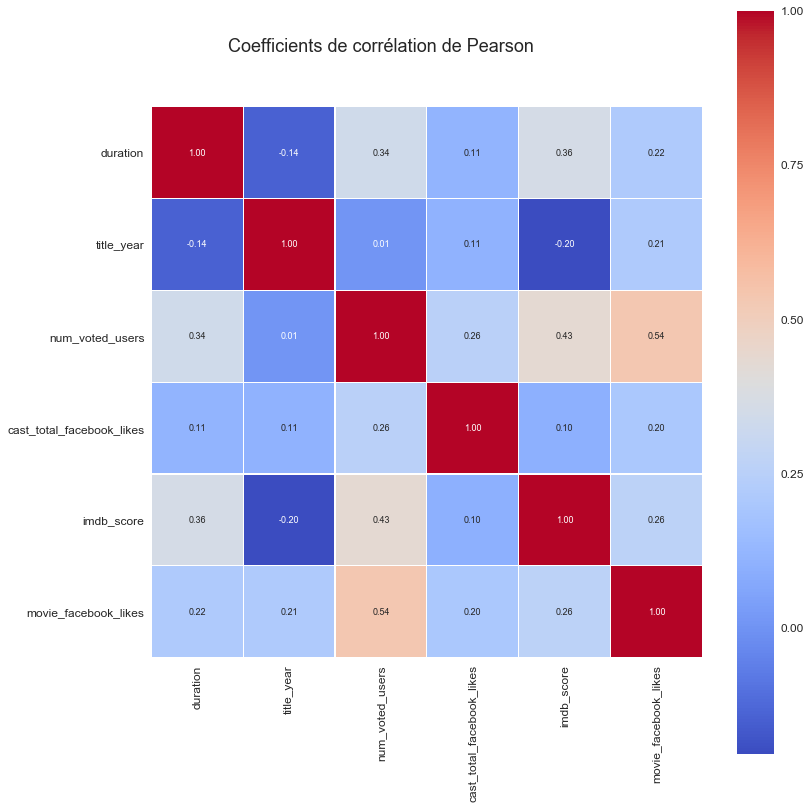

In [67]:
sns.set(font_scale = 1.2)
corrmat = data.dropna().loc[:, "movie_title":"movie_facebook_likes"].corr()
f, ax = plt.subplots(figsize=(12, 12))
f.text(0.45, 0.93, "Coefficients de corrélation de Pearson", ha='center', fontsize = 18)
sns.heatmap(corrmat, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 9}, square=True, linewidths=0.01, cmap="coolwarm")
plt.tight_layout()

On s'aperçoit que le score imdb n'est que faiblement corrélé au movie_facebook_likes, au cast_total_facebook_likes ou au director_facebook_likes. La colonne title_year est la seule corrélée de façon inverse et num_voted_users est la colonne ayant la plus grosse corrélation.

Globalement cette matrice ne nous permet pas d'éliminer de nouvelles colonnes, utilisons le PCA afin de réduire leur nombre.

## PCA

Du fait du très grand nombre de colonnes que nous avons, il peut être intéressant d'utiliser un PCA. Concentrons nous uniquement sur les colonnes de type "int" qui sont celles que nous avons ajoutées à l'aide du one hot encoding.

(4775, 1392)
[0.00340312 0.00325186 0.00290904 0.00255022 0.00238684 0.00226289
 0.00221667 0.00215038 0.00209496 0.00204662 0.00201701 0.00194512
 0.00193066 0.00191633 0.00188142 0.00186839 0.00185985 0.00185138
 0.00183091 0.00181658 0.00179825 0.00178601 0.00176936 0.00175881
 0.00174511 0.00173653 0.00173332 0.00172122 0.00171524 0.00171126
 0.00170798 0.001696   0.00169068 0.00168287 0.00167194 0.00166959
 0.001662   0.00165545 0.00164727 0.00163958 0.00163205 0.00162999
 0.00162451 0.00162061 0.00161816 0.00161374 0.00160423 0.00160319
 0.00159565 0.00159113 0.00158773 0.00157771 0.00157197 0.00156901
 0.00156262 0.00155793 0.00155382 0.00155162 0.00154849 0.00154066
 0.001538   0.00153398 0.0015297  0.00152685 0.00152524 0.0015217
 0.00152014 0.00151659 0.00151317 0.00150751 0.00150693 0.00150139
 0.00149527 0.00149284 0.00148884 0.00148685 0.00148436 0.00148081
 0.00147778 0.00147661 0.00147346 0.00147061 0.00146896 0.00146627
 0.00146493 0.00146195 0.0014582  0.0014535  0.001

(-0.7, 0.7)

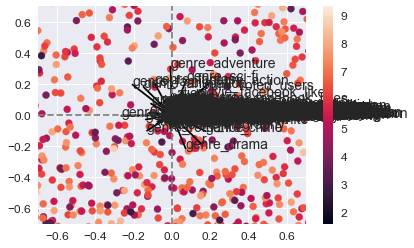

In [68]:
data = data.dropna()
columns = data.select_dtypes(['object']).columns
X = data.drop(columns=columns, axis=1)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

print(X_scaled.shape)
pca = decomposition.PCA(n_components=900)
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    c=data.get("imdb_score"))

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()

pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

On se rend compte que notre PCA n'est pas très concluant ici dans la mesure où avec près de 900 variables on explique 85% de la variance. Toutefois du fait des filtres déjà effectués cela ne devrait pas être un frein pour notre modèle et cela nous permet de garder des colonnes facilement interprétables.

## Sauvegarde

Ecrivons ce nouveau dataset sous csv afin d'en faire notre jeu de données cleanées.

In [69]:
data.to_csv("clean_data.csv", columns=data.columns, encoding="utf-8", index=False)